# Support Vector Machine for Classification Problem
### *Exploring the association between neoantigen-related variables and immune scores*
This notebook is the continuation of the `support_vector_reg.ipynb` notebook, detailing the testing of SVM application on our neoantigen dataset, converted into a classification problem.

#### **Package and Raw Data Loading**
First, import necessary packages and load in the raw data table into `pandas` dataFrame. 



In [1]:
# first, import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itables import show
from IPython.display import HTML, display
from warnings import simplefilter, filterwarnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

# load pretty jupyter's magics
%load_ext pretty_jupyter

Load up the cleaned-up dataset wrangled from MH's latest work.

In [2]:
# read in latest data
# use the 202409_new_excludedIHC_batch-duplicate-removed.tsv
df = pd.read_csv("../input-data/SA/202409_new_excludedIHC_batch-duplicate-removed.tsv",sep="\t")
print(f"Before trimming columns: {df.shape}")

# exclude the 29 Cibersort scores, leaving only 3
df = df.drop(columns=['Bindea_full', 'Expanded_IFNg', 
        'C_Bcellsmemory','C_Plasmacells','C_TcellsCD8','C_TcellsCD4naive',
         'C_TcellsCD4memoryactivated','C_Tcellsfollicularhelper',
         'C_Tcellsregulatory(Tregs)','C_Tcellsgammadelta','C_NKcellsresting',
         'C_NKcellsactivated', 'C_Monocytes', 'C_MacrophagesM0',
         'C_MacrophagesM1','C_Dendriticcellsresting',
         'C_Dendriticcellsactivated', 'C_Mastcellsresting',
         'C_Mastcellsactivated','C_Eosinophils', 'C_Neutrophils', 'S_PAM100HRD'])

print(f"After trimming columns: {df.shape}")
df.head()

Before trimming columns: (953, 156)
After trimming columns: (953, 134)


,ID,Batch,PAM50,Subtype,HR_status,HER_status,Age,AgeGroup,Stage,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestScore,FusionTransscript_Count,Fusion_T2NeoRate,SNVindelNeo_Count,SNVindelNeo_IC50,SNVindelNeo_IC50Percentile,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
0,SD0012,Batch_1,LumB,HR+/HER2-,HR+,HER2-,50.0,41-50,2.0,2.0,2.3,20.0,5.79,42.0,0.476190476,357.0,1.7,0.0025,377.0,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
1,SD0014,Batch_1,LumA,HR+/HER2-,HR+,HER2-,58.0,51-60,2.0,2.0,2.5,10.0,5.28,17.0,0.588235294,85.0,4.1,0.0039,95.0,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.27

#### **Data Preprocessing**

Decide all the clinical variables and neoantigen-related variables to keep in the X matrix (features).

1. `Subtype` column has already been encoded categorically by `HR_status` and `HER_status` columns so these two columns can be dropped. ***UPDATE: due to their lesser importance during the default XGBoost modeling, `PAM50` column was dropped as well.***

2.  `AgeGroup` is just a binned information of `Age` column so it is dropped as it is redundant.

~~3. Drop `FusionNeo_bestScore`, `FusionTransscript_Count`, `Fusion_T2NeoRate` columns as well as the `SNVindelNeo_IC50` and `SNVindelNeo_IC50Percentile` columns for now to reduce complexity.~~

4. Drop `Batch` column.

~~> **UPDATE 1: Exclude `TotalNeo_Count`, and include `Fusion_T2NeoRate` and `SNVindelNeo_IC50` columns.~~ Also, rename `Fusion_T2NeoRate` to `FN/FT_Ratio`.**

> **UPDATE 2: put back `FusionNeo_bestScore` into the X variable set and rename it into `FusionNeo_bestIC50`**

NOTE: The FN/FT_Ratio can go beyond 1. In this case this implies that there are more predicted neoantigens than there are predicted transcript. Imagine one transcript being able to produce more than 1 putative neoantigen. This implies a highly immunogenic transcript, so this metric might be useful down the line.

In [3]:
# let's drop all NaN for now and set col 'ID' as index
# dfd = df.drop(columns = ['Batch', 'Stage', 'PAM50', 'HR_status', 'HER_status', 'AgeGroup', 'TotalNeo_Count', 'FusionTransscript_Count', 'SNVindelNeo_IC50Percentile']).dropna().set_index('ID')
dfd = df.drop(columns = ['Batch', 'Stage', 'PAM50', 'HR_status', 'HER_status', 'AgeGroup', 'SNVindelNeo_IC50Percentile']).dropna().set_index('ID')

# rename the column `Fusion_T2NeoRate` to `FN/FT_Ratio` and `FusionNeo_bestScore` to `FusionNeo_bestIC50`
dfd.rename(columns={'Fusion_T2NeoRate': 'FN/FT_Ratio'}, inplace=True)
dfd.rename(columns={'FusionNeo_bestScore': 'FusionNeo_bestIC50'}, inplace=True)
dfd.rename(columns={'FusionTransscript_Count': 'FusionTranscript_Count'}, inplace=True)

print(dfd.shape)
dfd.head()

(674, 126)


,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50.0,2.0,2.3,20.0,5.79,42.0,0.476190476,357.0,1.7,377.0,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58.0,2.0,2.5,10.0,5.28,17.0,0.588235294,85.0,4.1,95.0,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.

**Sanity Check:** Check to make sure there is no duplicated index rows in the dataset.

In [4]:
print(dfd.index[dfd.index.duplicated()].unique())
rows_dupe = list(dfd.index[dfd.index.duplicated()].unique())
rows_dupe

Index([], dtype='object', name='ID')


[]

Now, We need to encode the `object` columns of `Subtype` and `FN/FT_Ratio` into appropriate types. Change `Age`, `TumorGrade`, and `IMPRES` into `int64` as well as all `*_Count` columns because they are discrete variables. Change the `FN/FT_Ratio` into `float64`.

In [5]:
dfd['Subtype'] = dfd['Subtype'].astype('category')
dfd['Age'] = dfd['Age'].astype('int64')
dfd['TumorGrade'] = dfd['TumorGrade'].astype('int64')
dfd['IMPRES'] = dfd['IMPRES'].astype('int64')
dfd['FusionNeo_Count'] = dfd['FusionNeo_Count'].astype('int64')
dfd['FusionTranscript_Count'] = dfd['FusionTranscript_Count'].astype('int64')
dfd['SNVindelNeo_Count'] = dfd['SNVindelNeo_Count'].astype('int64')
dfd['FN/FT_Ratio'] = dfd['FN/FT_Ratio'].astype('float64')

# print(dfd.dtypes)
pd.set_option('display.max_rows', 8)

In [6]:
# save dfd dataframe to a new file as a pandas object
dfd.to_pickle("../input-data/SA/202409_new_excludedIHC_batch-duplicate-removed_cols-dropped_coltypes_encoded.pkl")


Now we can use Feature_Engine's `OneHotEncoder()` to create a `k` dummy variable set for `Subtype`.

**NOTE**: The encoded columns will be appended at the end of the dataFrame. 


In [7]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(
    variables=['Subtype'],
    drop_last=False)

encoder.fit(dfd)
dfd_ = encoder.transform(dfd)
dfd_.head()

,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,50,2,2.3,20,5.79,42,0.476190,357,1.7,377.0,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530,1,0,0,0
SD0014,58,2,2.5,10,5.28,17,0.588235,85,4.1,95.0,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3

In [8]:
# Specify the encoded columns to shift
enc_cols = ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']

# Drop the specified columns and store them
encoded_df = dfd_[enc_cols]
dfenc = dfd.drop(columns=['Subtype'])

# Specify the index where you want to reinsert the columns
insert_index = 0  # This will insert at the first column

# Reinsert the columns
for i, col in enumerate(encoded_df.columns):
    dfenc.insert(insert_index + i, col, encoded_df[col])

Below is the categorically-encoded dataframe.

In [9]:
print(dfenc.shape)
dfenc.head()

(674, 129)


,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,1,0,0,0,50,2,2.3,20,5.79,42,0.476190,357,1.7,377.0,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,1,0,0,0,58,2,2.5,10,5.28,17,0.588235,85,4.1,95.0,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.

And below is the original, unencoded dataframe.

In [10]:
print(dfd.shape)
dfd.head()

(674, 126)


,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50,2,2.3,20,5.79,42,0.476190,357,1.7,377.0,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58,2,2.5,10,5.28,17,0.588235,85,4.1,95.0,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,HR+/HER2-,46,2,1.8

~~#### **Subsetting Y Labels**~~

~~In the previous exploration, many of the immune scores (Y targets/labels) might not really show much relationship with fusion neoantigen variables so they may not be as informative. We decided to use Caitlin's finding and subset the Y labels into several clinically meaningful groups.~~

In [11]:
# # use the unencoded categorical dataframe (dfd) and drop the Subtype categorical column
# df_dcat = dfd.drop(columns=['Subtype'])
# print(df_dcat.shape)
# df_dcat.head()

First list all the clinical variables that would be the X feature set.

In [12]:
X_features = ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+', 'Age', 'TumorGrade', 'TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FusionTranscript_Count', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50', 'TotalNeo_Count']

In [13]:
X_features_nocat = ['Age', 'TumorGrade', 'TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FusionTranscript_Count', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50', 'TotalNeo_Count']

In [14]:
# Now get the Y variable set
Y_labels_all = [col for col in dfd.drop(columns=['Subtype']).columns if col not in X_features]
print(Y_labels_all[:5])
len(Y_labels_all)

['ESTIMATE', 'IMPRES', 'C_Bcellsnaive', 'C_TcellsCD4memoryresting', 'C_MacrophagesM2']


115

#### **Split Dataset with `train_test_split` & Create a Data Transformation Pipeline from `feature_engine` Package**

Split the dataset before modeling to avoid information leakage.

Next, the pipeline will apply the Yeo-Johnson transformation on the split datasets on select X features and all Y labels, and scale them using `StandardScaler` (but wrapped within `feature_engine`'s wrapper) on select X features and all Y labels.

This pipeline would enable easy inverse transform steps for both X and Y datasets later.

In [15]:
# subset X columns as desired
X = dfenc[X_features]
X = X.drop(columns=["FusionNeo_bestIC50", "SNVindelNeo_IC50"])
X

,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,TotalNeo_Count
ID,,,,,,,,,,,,
SD0012,1,0,0,0,50,2,2.3,20,42,0.476190,357,377.0
SD0014,1,0,0,0,58,2,2.5,10,17,0.588235,85,95.0
SD0015,1,0,0,0,46,2,1.8,4,16,0.250000,150,154.0
SD0017,1,0,0,0,54,2,2.5,19,47,0.404255,1369,1388.0
...,...,...,...,...,...,...,...,...,...,...,...,...
SD2406,1,0,0,0,72,2,3.0,13,33,0.393939,512,525.0
SD2409,1,0,0,0,50,2,2.0,4,3,1.333333,26,30.0
SD2412,1,0,0,0,49,2,3.5,12,52,0.230769,80,92.0
SD2418,1,0,0,0,74,2,2.2,17,22,0.772727,264,281.0


In [16]:
X['TumorGrade'].max()

np.int64(3)

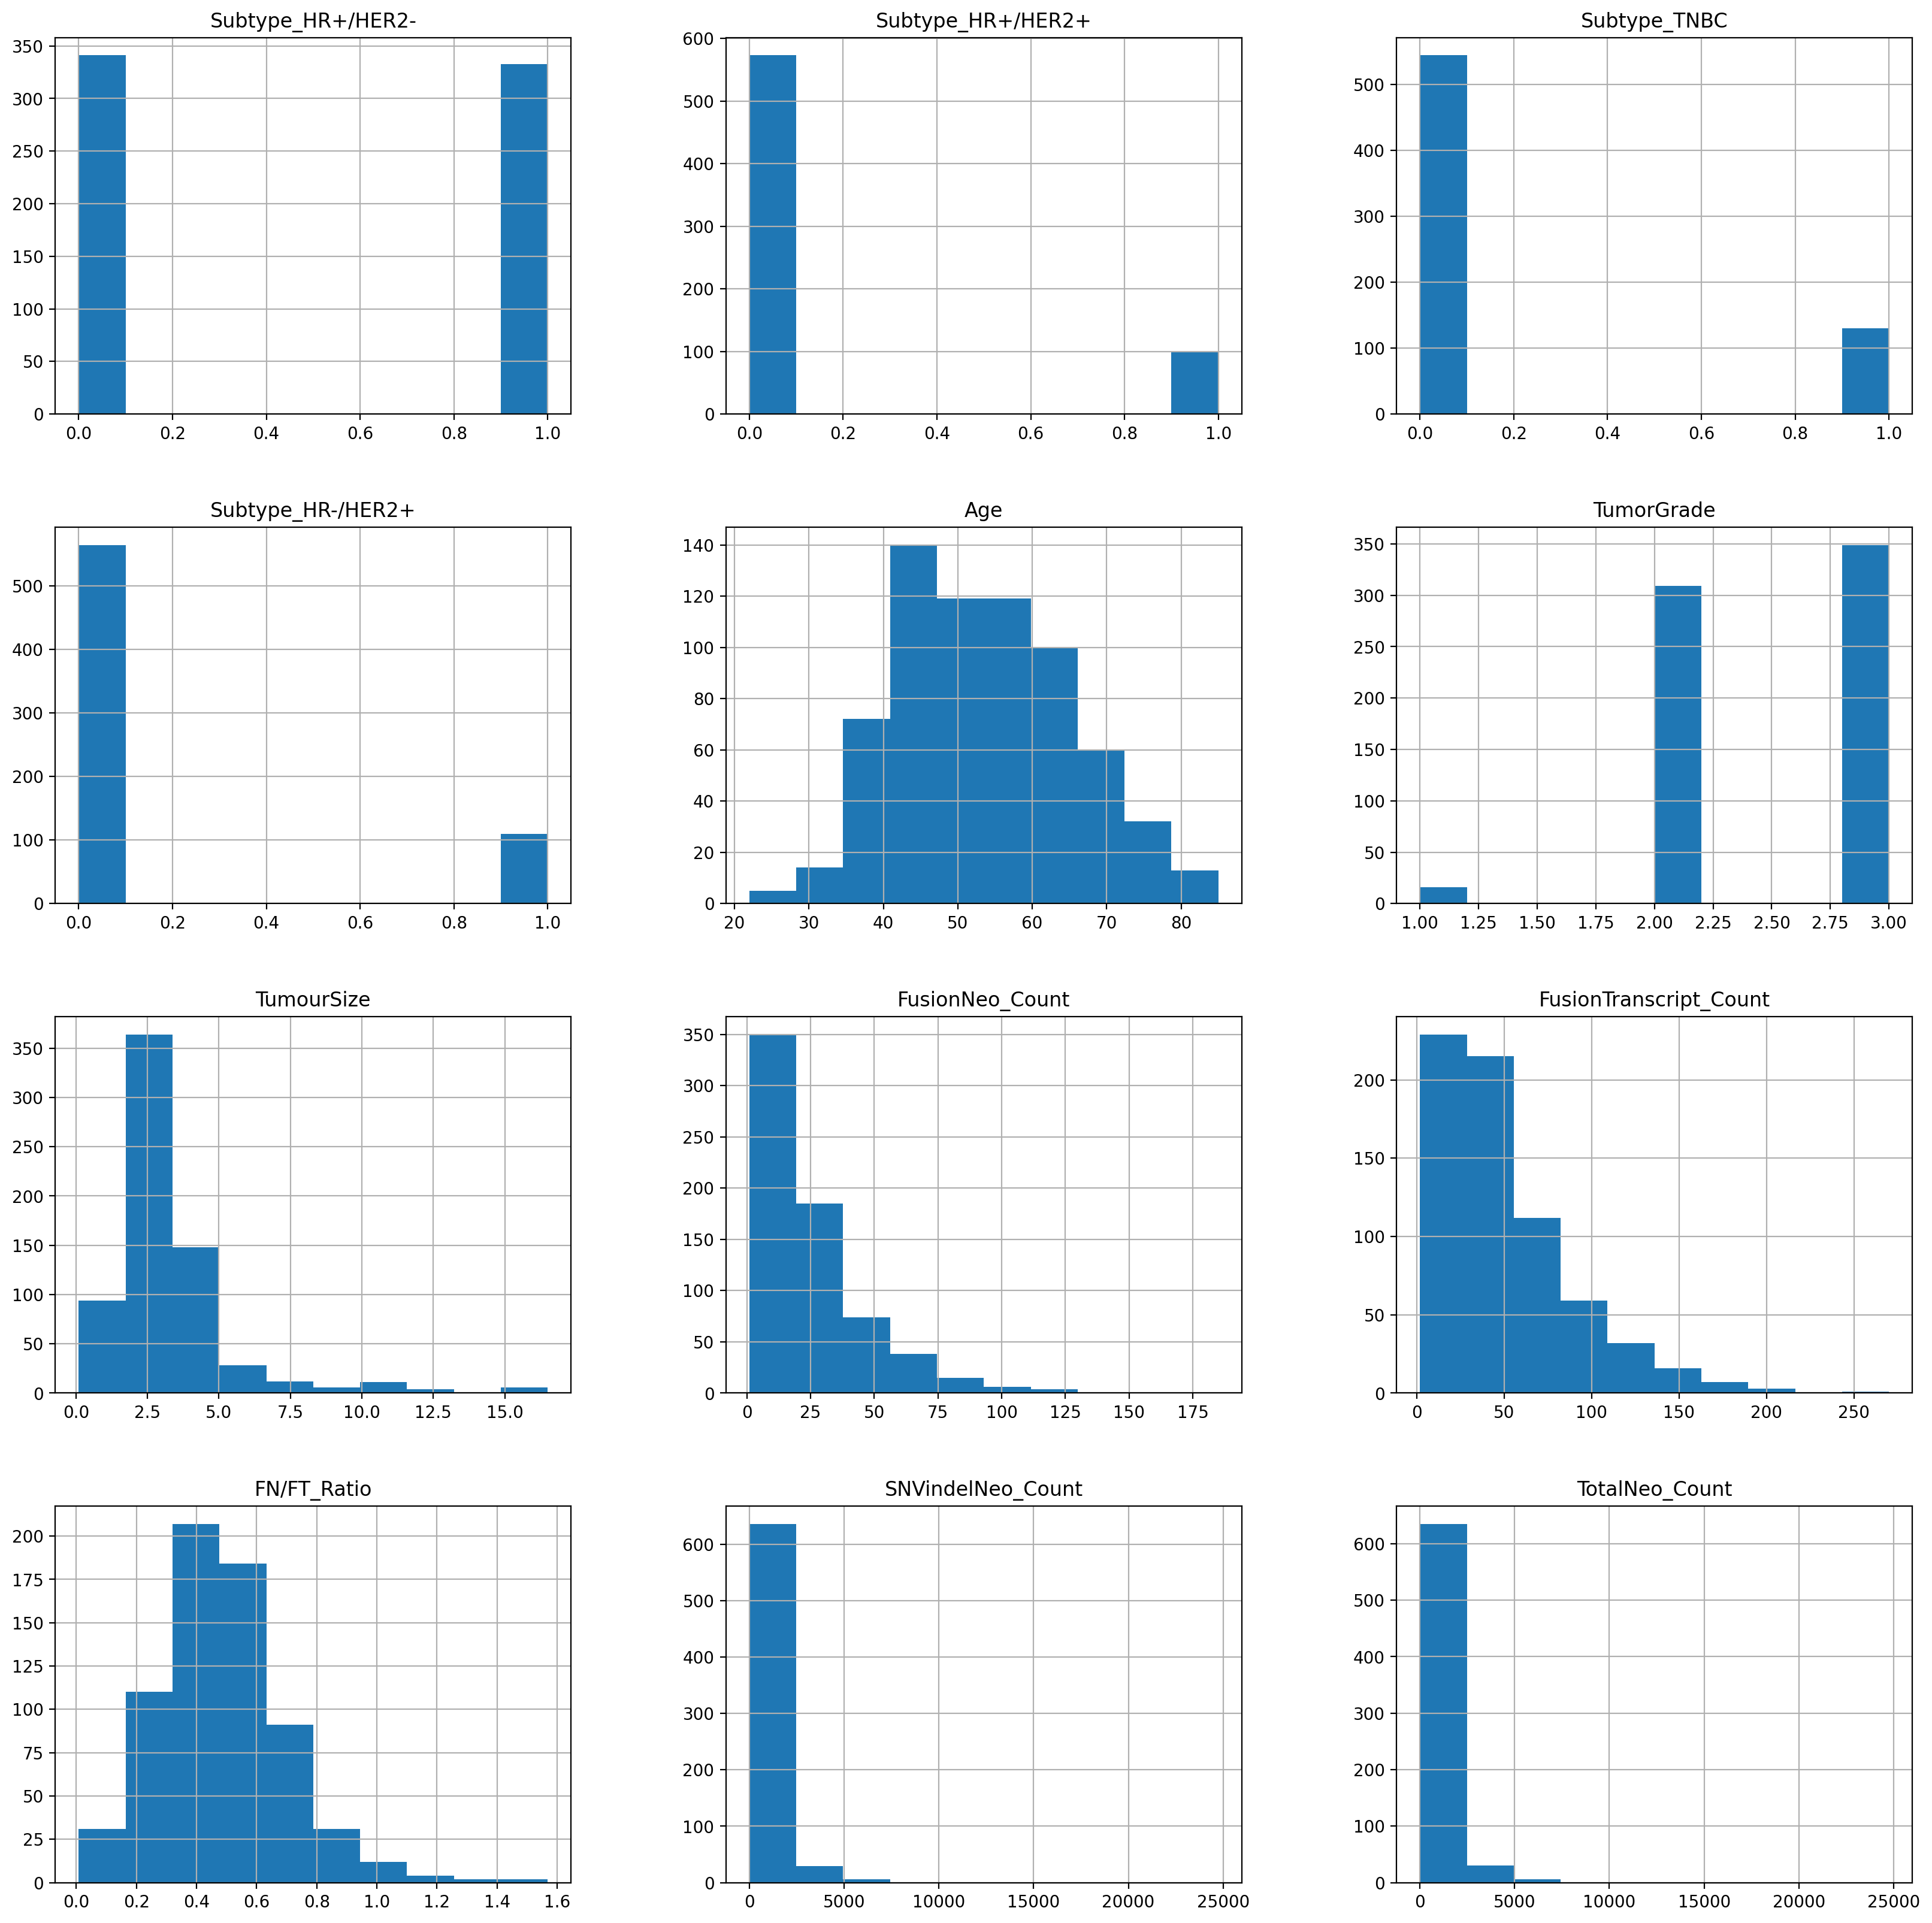

In [17]:
# plot distribution of the X columns
X.hist(figsize=(20, 20))
plt.show()

Now grab the Y targets (do this as a whole, but we will train on each column individually later).

In [18]:
# Now get the Y variable set
Y = dfenc[Y_labels_all]
# # select variables to target
# cols_Y = Y.columns.tolist()
# # drop ESTIMATE and IMPRES
# target_cols_Y = [col for col in cols_Y if col not in ['ESTIMATE', 'IMPRES']]
Y

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,3123.055856,8,0.162653,0.235337,0.279972,0.3556,0.3782,0.3363,0.4718,0.3015,0.2659,0.2274,0.3180,0.3025,0.3124,0.2622,0.2304,0.2706,0.3761,0.4613,0.3814,0.3055,0.2764,0.3211,0.3784,-0.1955,0.3122,0.1932,0.2485,0.2211,0.2004,0.2478,0.3040,0.3316,0.3646,0.3483,0.3012,0.4038,0.3875,0.3158,

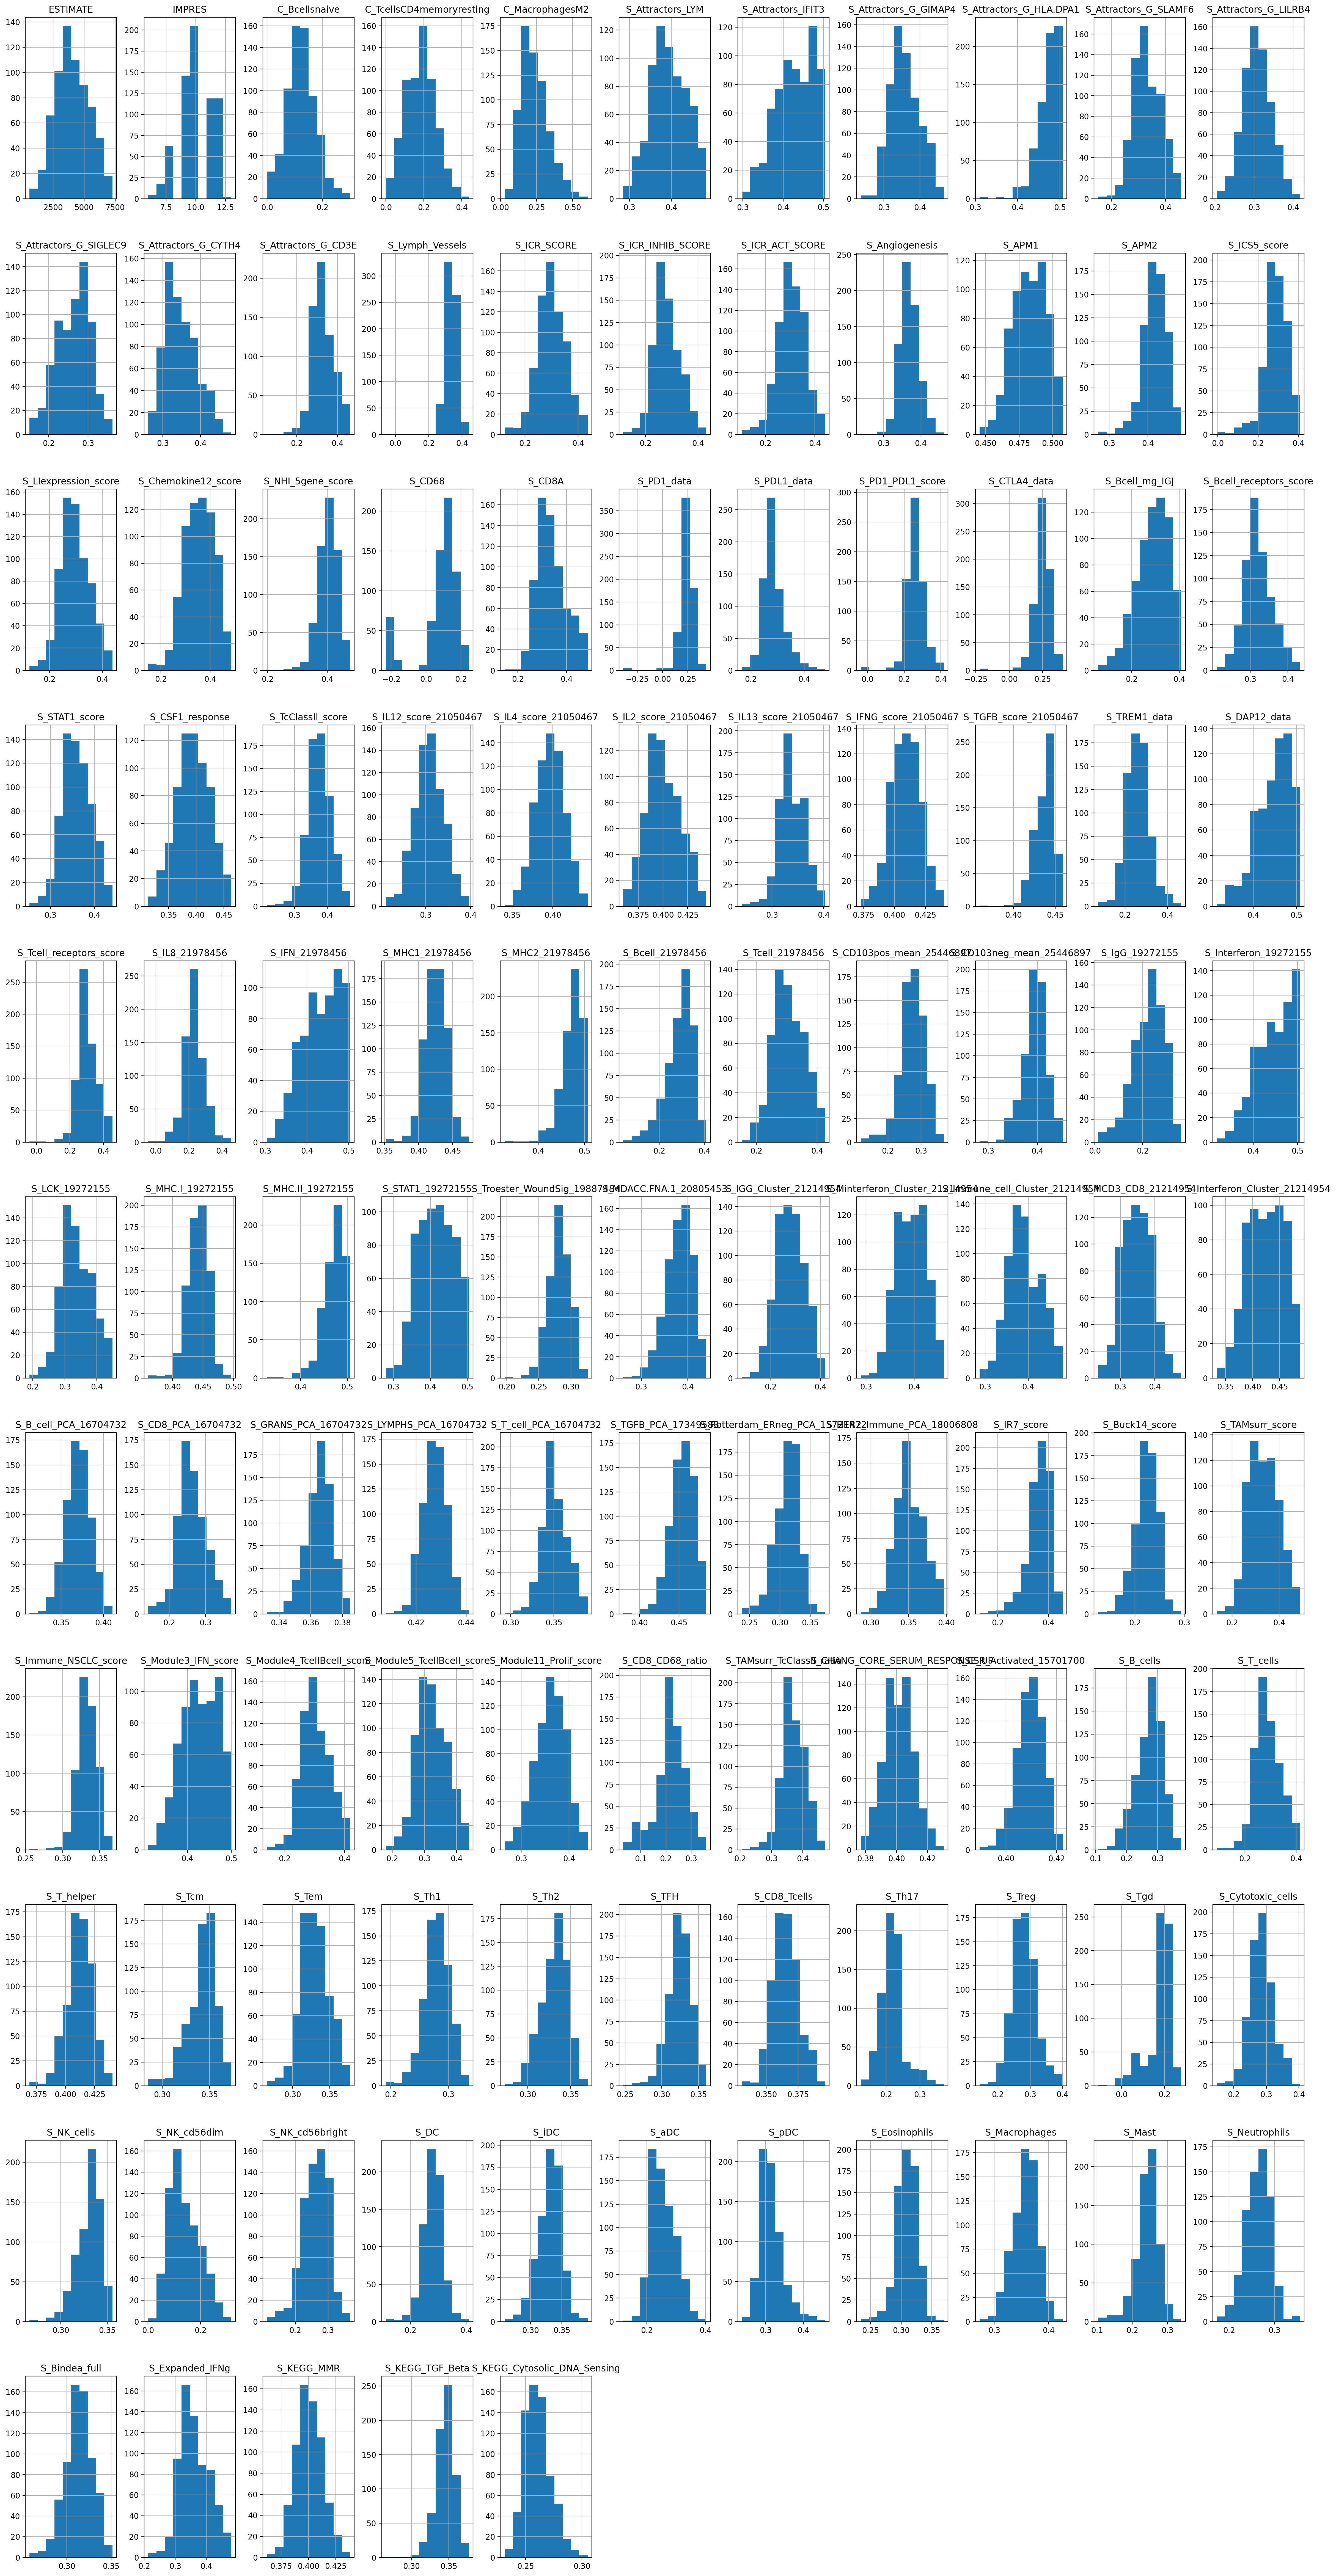

In [19]:
Y.hist(figsize=(30, 60))
plt.show()

Now we perform train test split on the X and Y variables then create a data transformation pipeline to scale the data.

In [20]:
# Perform train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
X_train

,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,TotalNeo_Count
ID,,,,,,,,,,,,
SD0907,0,0,0,1,64,2,2.5,47,81,0.580247,177,224.0
SD0850,1,0,0,0,50,3,2.0,20,51,0.392157,362,382.0
SD0050,0,1,0,0,45,3,4.0,37,69,0.536232,317,354.0
SD1753,1,0,0,0,73,2,3.0,1,6,0.166667,63,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...
SD0339,0,0,0,1,66,3,3.5,117,199,0.587940,284,401.0
SD0994,0,1,0,0,64,3,3.5,6,35,0.171429,138,144.0
SD1532,1,0,0,0,67,2,2.5,55,93,0.591398,543,598.0
SD0326,0,0,0,1,43,2,5.0,74,98,0.755102,196,270.0


In [22]:
X_test

,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionTranscript_Count,FN/FT_Ratio,SNVindelNeo_Count,TotalNeo_Count
ID,,,,,,,,,,,,
SD2074,0,0,1,0,37,3,2.0,16,41,0.390244,1733,1749.0
SD1111,1,0,0,0,45,2,4.0,64,124,0.516129,361,425.0
SD2130,0,0,1,0,64,2,2.5,16,45,0.355556,455,471.0
SD1765,1,0,0,0,35,3,3.7,10,39,0.256410,114,124.0
...,...,...,...,...,...,...,...,...,...,...,...,...
SD0129,1,0,0,0,45,3,2.8,22,41,0.536585,222,244.0
SD0793,1,0,0,0,39,2,1.8,10,31,0.322581,199,209.0
SD1751,1,0,0,0,41,2,2.0,5,4,1.250000,277,282.0
SD1497,1,0,0,0,44,2,2.5,13,37,0.351351,81,94.0


In [23]:
Y_train.head()

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0907,5087.085018,12,0.118125,0.256480,0.165096,0.4142,0.4760,0.3919,0.4921,0.3844,0.3343,0.3073,0.3640,0.3604,0.3475,0.3574,0.3291,0.3648,0.3590,0.4875,0.4452,0.3611,0.3395,0.4598,0.4458,0.1021,0.3835,0.2815,0.3298,0.3058,0.2838,0.3775,0.3519,0.3987,0.4151,0.4071,0.3404,0.3838,0.4119,0.3754,0.4066,0.4280,0.2817,0.4651,0.3490,0.2439,0.4762,0.4304,0.4948,0.3513,0.3549,0.2850,0.3981,0.2854,0.4880,0.3775,0.4485,0.4918,0.4791,0.2630,0.4153,0.3499,0.4350,0.4301,0.2917,0.4557,0.3866,0.2994,0.3660,0.4321,0.3605,0.4424,0.2864,0.3656,0.3989,0.2009,0.4268,0.3502,0.4724,0.3500,0.3830,0.3950,0.2495,0.4101,0.4071,0.4079,0.3258,0.3354,0.4259,0.3548,0.3213,0.2933,0.3484,0.3260,0.3699,0.2996,0.2953,0.2180,0.3140,0.3230,0.2266,0.2121,0.3060,0.3194,0.2668,0.3132,0.2935,0.3684,0.2259,0.2696,0.3235,0.4169,0.4112,0.3337,0.2683
SD0850,3163.224848,8,0.103919,0.070753,0.272750,0.3671,0.4333,0.3166,0.4604,0.2911,0.3122,0.2923,0.3237,0.2783,0.3638,0.2715,0.2473,0.2778,0.3736,0.4796,0.4076,0.2594,0.2585,0.3186,0.3881,0.1263,0.2680,0.2008,0.2537,0.2275,0.2207,0.2605,0.2971,0.3442,0.3749,0.3534,0.2832,0.3780,0.3914,0.3175,0.4106,0.4416,0.2741,0.4535,0.2492,0.2219,0.4382,0.4149,0.4703,0.2862,0.2611,0.2523,0.3920,0.2026,0.4519,0.2968,0.4346,0.4557,0.3906,0.2755,0.3700,0.2613,0.3745,0.3611,0.3533,0.4229,0.3573,0.2310,0.3660,0.4276,0.3390,0.4695,0.3083,0.3412,0.3574,0.2084,0.2990,0.3441,0.4180,0.2639,0.2924,0.3733,0.1990,0.3454,0.4057,0.4087,0.2290,0.2362,0.3941,0.3289,0.3481,0.2934,0.3342,0.3221,0.3567,0.2165,0.2536,0.2100,0.2410,0.3423,0.0885,0.2069,0.2714,0.3312,0.2219,0.3227,0.3014,0.3508,0.2695,0.2609,0.3048,0.3224,0.4007,0.3404,0.2573
SD0050,4215.075265,9,0.124727,0.201551,0.296744,0.3905,0.4879,0.3591,0.4701,0.3449,0.3283,0.2246,0.3498,0.3356,0.3269,0.3364,0.3310,0.3378,0.3513,0.4981,0.4267,0.3270,0.2981,0.4290,0.4172,-0.1712,0.3271,0.2721,0.3271,0.2999,0.2867,0.3088,0.3227,0.3884,0.4028,0.3846,0.3260,0.3925,0.4006,0.3335,

In [24]:
Y_test.head()

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD2074,6298.348720,12,0.144277,0.263354,0.129438,0.4637,0.4316,0.4234,0.5012,0.4227,0.3403,0.2362,0.4146,0.4212,0.3015,0.3823,0.3642,0.3870,0.3737,0.5014,0.4586,0.3632,0.3987,0.4283,0.4029,0.1357,0.4523,0.3056,0.3331,0.3194,0.3267,0.3325,0.3922,0.4076,0.4372,0.4356,0.3595,0.4158,0.4330,0.3661,0.4261,0.4361,0.2548,0.4765,0.4048,0.3095,0.4370,0.4355,0.5018,0.3202,0.4022,0.3415,0.4034,0.2821,0.4510,0.4248,0.4487,0.4994,0.4793,0.2980,0.4146,0.3385,0.4199,0.4558,0.3769,0.4344,0.3951,0.3334,0.3751,0.4340,0.3770,0.4506,0.2911,0.3848,0.4175,0.2624,0.3971,0.3351,0.4384,0.3912,0.4019,0.3952,0.3019,0.4300,0.4093,0.4197,0.3269,0.3849,0.4278,0.3640,0.3455,0.3045,0.3443,0.3325,0.3868,0.1960,0.3130,0.2291,0.3469,0.3415,0.2146,0.2595,0.3266,0.3466,0.2707,0.3400,0.3083,0.3764,0.2438,0.2864,0.3369,0.4440,0.4023,0.3589,0.2676
SD1111,3646.460101,10,0.138158,0.276951,0.295168,0.3862,0.4033,0.3793,0.4819,0.3164,0.2823,0.2664,0.3343,0.3170,0.3685,0.2839,0.2553,0.2914,0.4102,0.4737,0.4017,0.2782,0.2747,0.3463,0.4038,0.0748,0.3354,0.2199,0.2758,0.2481,0.2231,0.2982,0.3073,0.3437,0.3867,0.3656,0.3093,0.4135,0.4003,0.3314,0.4001,0.4404,0.2260,0.3952,0.2968,0.2174,0.4019,0.4093,0.4675,0.2916,0.3037,0.2972,0.4034,0.2302,0.4219,0.3383,0.4223,0.4736,0.3846,0.3030,0.3930,0.2904,0.3794,0.3756,0.4199,0.4003,0.3736,0.2727,0.3657,0.4288,0.3567,0.4507,0.3199,0.3482,0.3632,0.2344,0.2913,0.3291,0.4012,0.3001,0.3059,0.3318,0.2111,0.3548,0.3902,0.4046,0.2812,0.2946,0.4301,0.3645,0.3309,0.2757,0.3395,0.3370,0.3747,0.2035,0.2506,0.2246,0.2865,0.3331,0.1038,0.2975,0.2943,0.3302,0.2237,0.3061,0.3345,0.3507,0.2595,0.2784,0.3216,0.3426,0.3854,0.3683,0.2471
SD2130,1835.122109,8,0.000000,0.359865,0.276729,0.3210,0.3913,0.2965,0.4416,0.2540,0.2690,0.2575,0.2824,0.2259,0.3488,0.2247,0.2417,0.2201,0.3579,0.4681,0.3848,0.1064,0.1964,0.2555,0.3650,0.1430,0.2481,0.1235,0.2876,0.2078,0.1624,0.1402,0.2606,0.3001,0.3560,0.3235,0.2656,0.3997,0.3784,0.3620,

In [25]:
# select variables to scale
cols_X = X_train.columns.tolist()
scale_cols_X = [col for col in cols_X if col not in ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']]
scale_cols_X

['Age',
 'TumorGrade',
 'TumourSize',
 'FusionNeo_Count',
 'FusionTranscript_Count',
 'FN/FT_Ratio',
 'SNVindelNeo_Count',
 'TotalNeo_Count']

In [26]:
categorical_cols_X = ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']

#### **Dataset Binning**

To test SVM, we need to bin the target Y datasets into discrete classes. We can leave X datasets as they are (transformed and scaled). 

In [27]:
# from feature_engine.pipeline import Pipeline
# from feature_engine.transformation import YeoJohnsonTransformer
# from feature_engine.wrappers import SklearnTransformerWrapper
# from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
# from sklearn.compose import ColumnTransformer
# from typing import Dict
# import pandas as pd

# # Separate numeric and categorical preprocessing
# numeric_transformer = Pipeline([
#     ('yeo_johnson', YeoJohnsonTransformer(variables=scale_cols_X)),
#     ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=scale_cols_X))
# ])

# # Create column transformer for X preprocessing
# preprocess_pipeline_X = ColumnTransformer(
#     transformers=[
#         ('numeric', numeric_transformer, scale_cols_X),
#         ('categorical', 'passthrough', categorical_cols_X)  # Assuming categorical_cols is your list of one-hot columns
#     ],
#     remainder='passthrough'  # This will pass through any columns not explicitly specified
# )

# # Simplified Y preprocessing - only binning for classification
# class MultiColumnBinner:
#     def __init__(self, n_bins=3, strategy='quantile'):
#         self.n_bins = n_bins
#         self.strategy = strategy
#         self.binner = None
#         self.bin_edges_ = None
        
#     def fit(self, X, y=None):
#         self.binner = KBinsDiscretizer(
#             n_bins=self.n_bins,
#             encode='ordinal',
#             strategy=self.strategy
#         )
#         self.binner.fit(X)
#         self.bin_edges_ = self.binner.bin_edges_
#         return self
    
#     def transform(self, X):
#         binned = self.binner.transform(X)
#         return pd.DataFrame(
#             binned,
#             columns=X.columns,
#             index=X.index
#         )
    
#     def fit_transform(self, X, y=None):
#         return self.fit(X).transform(X)

# # Simplified Y pipeline - only binning
# preprocess_pipeline_Y = Pipeline([
#     ('binner', MultiColumnBinner(n_bins=3, strategy='quantile'))
# ])

# # Modified process X data - note that we need to convert to DataFrame after transformation
# preprocess_pipeline_X.fit(X_train)
# X_train_transformed = pd.DataFrame(
#     preprocess_pipeline_X.transform(X_train),
#     columns=list(scale_cols_X) + list(categorical_cols_X),  # Maintain column names
#     index=X_train.index
# )
# X_test_transformed = pd.DataFrame(
#     preprocess_pipeline_X.transform(X_test),
#     columns=list(scale_cols_X) + list(categorical_cols_X),  # Maintain column names
#     index=X_test.index
# )

# # Process Y data - now only binning
# preprocess_pipeline_Y.fit(Y_train)
# Y_train_binned = preprocess_pipeline_Y.transform(Y_train)
# Y_test_binned = preprocess_pipeline_Y.transform(Y_test)

# # Print bin edges for interpretation
# binner = preprocess_pipeline_Y.steps[0][1]
# for col, edges in zip(Y_train.columns, binner.bin_edges_):
#     print(f"\nBin edges for {col}:")
#     print(f"low (0): <= {edges[1]:.2f}")
#     print(f"mid (1): {edges[1]:.2f} to {edges[2]:.2f}")
#     print(f"high (2): > {edges[2]:.2f}")

Now run SVM.

In [28]:
####### THIS IS THE NON-GRIDSEARCH VERSION #########
# def run_classification_model(
#     y_target: str,
#     Y_train_binned: pd.DataFrame,
#     Y_test_binned: pd.DataFrame,
#     X_train_transformed: pd.DataFrame,
#     X_test_transformed: pd.DataFrame,
# ) -> Dict:
#     """Run classification model for a single target variable and return performance metrics."""
#     from sklearn.svm import SVC
#     from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
#     import matplotlib.pyplot as plt
#     import os
    
#     # Get binned target data
#     y_train = Y_train_binned[y_target].astype(int)
#     y_test = Y_test_binned[y_target].astype(int)
    
#     # Initialize and fit model
#     model = SVC(kernel='rbf', probability=True)
#     model.fit(X_train_transformed, y_train)
    
#     # Predict
#     y_train_pred = model.predict(X_train_transformed)
#     y_test_pred = model.predict(X_test_transformed)
    
#     # Calculate metrics
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Generate classification report
#     test_report = classification_report(y_test, y_test_pred)
    
#     # Create and save confusion matrix plots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
#     ConfusionMatrixDisplay.from_predictions(
#         y_train, y_train_pred,
#         display_labels=['low', 'mid', 'high'],
#         ax=ax1
#     )
#     ax1.set_title('Training Confusion Matrix')
    
#     ConfusionMatrixDisplay.from_predictions(
#         y_test, y_test_pred,
#         display_labels=['low', 'mid', 'high'],
#         ax=ax2
#     )
#     ax2.set_title('Testing Confusion Matrix')
    
#     plt.tight_layout()
#     os.makedirs(f'plots-classification/{y_target}', exist_ok=True)
#     plt.savefig(f'plots-classification/{y_target}/{y_target}-classification-confusion-matrix.png')
#     plt.close()
    
#     return {
#         'target_name': y_target,
#         'train_accuracy': train_accuracy,
#         'test_accuracy': test_accuracy,
#         'classification_report': test_report
#     }

# # Example usage for all targets
# results_dict = {}
# for y_target in Y_train.columns:
#     print(f"\nProcessing target: {y_target}")
#     results = run_classification_model(
#         y_target=y_target,
#         Y_train_binned=Y_train_binned,
#         Y_test_binned=Y_test_binned,
#         X_train_transformed=X_train_transformed,
#         X_test_transformed=X_test_transformed
#     )
#     results_dict[y_target] = results
    
#     print(f"Results for {y_target}:")
#     print(f"Train accuracy: {results['train_accuracy']:.4f}")
#     print(f"Test accuracy: {results['test_accuracy']:.4f}")
#     print("\nClassification Report:")
#     print(results['classification_report'])

In [29]:
# import pandas as pd
# from typing import Dict

# def analyze_model_performances(results_dict: Dict) -> pd.DataFrame:
#     """
#     Analyze performance metrics across all target variables.
    
#     Args:
#         results_dict: Dictionary containing results from run_classification_model
        
#     Returns:
#         DataFrame with sorted performance metrics
#     """
#     # Create a list to store performance metrics
#     performances = []
    
#     for target, results in results_dict.items():
#         performances.append({
#             'target': target,
#             'train_accuracy': results['train_accuracy'],
#             'test_accuracy': results['test_accuracy'],
#             'difference': results['train_accuracy'] - results['test_accuracy']  # to check overfitting
#         })
    
#     # Convert to DataFrame
#     perf_df = pd.DataFrame(performances)
    
#     # Sort by test accuracy (primary metric) in descending order
#     perf_df_sorted = perf_df.sort_values('test_accuracy', ascending=False)
    
#     # Print the best performing target
#     best_target = perf_df_sorted.iloc[0]
#     print("\nBest performing target:")
#     print(f"Target: {best_target['target']}")
#     print(f"Test Accuracy: {best_target['test_accuracy']:.4f}")
#     print(f"Train Accuracy: {best_target['train_accuracy']:.4f}")
#     print(f"Difference (Train-Test): {best_target['difference']:.4f}")
    
#     print("\nAll targets sorted by test accuracy:")
#     print(perf_df_sorted.to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
#     # Identify potential overfitting cases
#     overfitting_threshold = 0.1  # You can adjust this threshold
#     overfitting_cases = perf_df[perf_df['difference'] > overfitting_threshold]
    
#     if not overfitting_cases.empty:
#         print("\nPotential overfitting cases (Train-Test > 0.1):")
#         print(overfitting_cases.to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
#     return perf_df_sorted

# # After running your models, use this to analyze:
# performance_summary = analyze_model_performances(results_dict)

# # If you want to get just the top N performing targets
# N = 5  # Change this to get more or fewer top performers
# top_N_targets = performance_summary.head(N)
# print(f"\nTop {N} performing targets:")
# print(top_N_targets.to_string(float_format=lambda x: '{:.4f}'.format(x)))

# # Get the classification report for the best performing target
# best_target = performance_summary.iloc[0]['target']
# print(f"\nDetailed classification report for best target ({best_target}):")
# print(results_dict[best_target]['classification_report'])

#### **Iterative Learning over Y Labels with `GridSearchCV` for Hyperparameter Tuning**

Now we can rewrite the functions to incorporate `GridSearchCV`.

In [30]:
# def run_classification_model(
#     y_target: str,
#     Y_train_binned: pd.DataFrame,
#     Y_test_binned: pd.DataFrame,
#     X_train_transformed: pd.DataFrame,
#     X_test_transformed: pd.DataFrame,
# ) -> Dict:
#     """Run classification model with GridSearchCV for a single target variable and return performance metrics."""
#     from sklearn.svm import SVC
#     from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
#     from sklearn.model_selection import GridSearchCV
#     import matplotlib.pyplot as plt
#     import os
    
#     # Get binned target data
#     y_train = Y_train_binned[y_target].astype(int)
#     y_test = Y_test_binned[y_target].astype(int)
    
#     # Define parameter grid
#     param_grid = {
#         'C': [0.1, 1, 10, 100],
#         'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
#         'kernel': ['rbf', 'linear'],
#         'class_weight': [None, 'balanced']
#     }
    
#     # Initialize base model
#     base_model = SVC(probability=True, random_state=42)
    
#     # Initialize GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=base_model,
#         param_grid=param_grid,
#         cv=5,
#         scoring='accuracy',
#         n_jobs=-1,
#         verbose=1
#     )
    
#     # Fit GridSearchCV
#     grid_search.fit(X_train_transformed, y_train)
    
#     # Get best model
#     best_model = grid_search.best_estimator_
    
#     # Predict using best model
#     y_train_pred = best_model.predict(X_train_transformed)
#     y_test_pred = best_model.predict(X_test_transformed)
    
#     # Calculate metrics
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Generate classification report
#     test_report = classification_report(y_test, y_test_pred)
    
#     # Create and save confusion matrix plots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
#     ConfusionMatrixDisplay.from_predictions(
#         y_train, y_train_pred,
#         display_labels=['low', 'mid', 'high'],
#         ax=ax1
#     )
#     ax1.set_title('Training Confusion Matrix')
    
#     ConfusionMatrixDisplay.from_predictions(
#         y_test, y_test_pred,
#         display_labels=['low', 'mid', 'high'],
#         ax=ax2
#     )
#     ax2.set_title('Testing Confusion Matrix')
    
#     plt.tight_layout()
#     os.makedirs(f'plots-classification/{y_target}', exist_ok=True)
#     plt.savefig(f'plots-classification/{y_target}/{y_target}-classification-confusion-matrix.png')
#     plt.close()
    
#     return {
#         'target_name': y_target,
#         'train_accuracy': train_accuracy,
#         'test_accuracy': test_accuracy,
#         'classification_report': test_report,
#         'best_params': grid_search.best_params_,
#         'cv_results': grid_search.cv_results_,
#         'best_score': grid_search.best_score_
#     }

# # Example usage for all targets
# results_dict = {}
# for y_target in Y_train.columns:
#     print(f"\nProcessing target: {y_target}")
#     results = run_classification_model(
#         y_target=y_target,
#         Y_train_binned=Y_train_binned,
#         Y_test_binned=Y_test_binned,
#         X_train_transformed=X_train_transformed,
#         X_test_transformed=X_test_transformed
#     )
#     results_dict[y_target] = results
    
#     print(f"Results for {y_target}:")
#     print(f"Best parameters: {results['best_params']}")
#     print(f"Best cross-validation score: {results['best_score']:.4f}")
#     print(f"Train accuracy: {results['train_accuracy']:.4f}")
#     print(f"Test accuracy: {results['test_accuracy']:.4f}")
#     print("\nClassification Report:")
#     print(results['classification_report'])

In [31]:
# import pandas as pd
# from typing import Dict

# def analyze_model_performances(results_dict: Dict) -> pd.DataFrame:
#     """
#     Analyze performance metrics across all target variables.
    
#     Args:
#         results_dict: Dictionary containing results from run_classification_model
        
#     Returns:
#         DataFrame with sorted performance metrics
#     """
#     # Create a list to store performance metrics
#     performances = []
    
#     for target, results in results_dict.items():
#         performances.append({
#             'target': target,
#             'train_accuracy': results['train_accuracy'],
#             'test_accuracy': results['test_accuracy'],
#             'difference': results['train_accuracy'] - results['test_accuracy']  # to check overfitting
#         })
    
#     # Convert to DataFrame
#     perf_df = pd.DataFrame(performances)
    
#     # Sort by test accuracy (primary metric) in descending order
#     perf_df_sorted = perf_df.sort_values('test_accuracy', ascending=False)
    
#     # Print the best performing target
#     best_target = perf_df_sorted.iloc[0]
#     print("\nBest performing target:")
#     print(f"Target: {best_target['target']}")
#     print(f"Test Accuracy: {best_target['test_accuracy']:.4f}")
#     print(f"Train Accuracy: {best_target['train_accuracy']:.4f}")
#     print(f"Difference (Train-Test): {best_target['difference']:.4f}")
    
#     print("\nAll targets sorted by test accuracy:")
#     print(perf_df_sorted.to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
#     # Identify potential overfitting cases
#     overfitting_threshold = 0.1  # You can adjust this threshold
#     overfitting_cases = perf_df[perf_df['difference'] > overfitting_threshold]
    
#     if not overfitting_cases.empty:
#         print("\nPotential overfitting cases (Train-Test > 0.1):")
#         print(overfitting_cases.to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
#     return perf_df_sorted

# # After running your models, use this to analyze:
# performance_summary = analyze_model_performances(results_dict)

# # If you want to get just the top N performing targets
# N = 5  # Change this to get more or fewer top performers
# top_N_targets = performance_summary.head(N)
# print(f"\nTop {N} performing targets:")
# print(top_N_targets.to_string(float_format=lambda x: '{:.4f}'.format(x)))

# # Get the classification report for the best performing target
# best_target = performance_summary.iloc[0]['target']
# print(f"\nDetailed classification report for best target ({best_target}):")
# print(results_dict[best_target]['classification_report'])

### Rebinning into just two classes

Instead of doing ternary classifications, let's try to just split things into two classes. High and low immune response.

In [32]:
from feature_engine.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from typing import Dict
import pandas as pd

# Separate numeric and categorical preprocessing
numeric_transformer = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer(variables=scale_cols_X)),
    ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=scale_cols_X))
])

# Create column transformer for X preprocessing
preprocess_pipeline_X = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, scale_cols_X),
        ('categorical', 'passthrough', categorical_cols_X)
    ],
    remainder='passthrough'
)

# Modified Y preprocessing for binary classification
class BinaryColumnBinner:
    def __init__(self, strategy='median'):
        """
        Initialize binary binner
        strategy: 'median' or 'mean' for splitting point
        """
        self.strategy = strategy
        self.binner = None
        self.split_points_ = {}
        
    def fit(self, X, y=None):
        """Fit the binner by calculating split points for each column"""
        self.split_points_ = {}
        for column in X.columns:
            if self.strategy == 'median':
                split_point = X[column].median()
            else:  # mean
                split_point = X[column].mean()
            self.split_points_[column] = split_point
        return self
    
    def transform(self, X):
        """Transform the data into binary classes (0 for low, 1 for high)"""
        X_binned = pd.DataFrame(index=X.index)
        for column in X.columns:
            split_point = self.split_points_[column]
            X_binned[column] = (X[column] > split_point).astype(int)
        return X_binned
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Modified Y pipeline for binary classification
preprocess_pipeline_Y = Pipeline([
    ('binner', BinaryColumnBinner(strategy='median'))  # or 'mean' if preferred
])

# Process X data
preprocess_pipeline_X.fit(X_train)
X_train_transformed = pd.DataFrame(
    preprocess_pipeline_X.transform(X_train),
    columns=list(scale_cols_X) + list(categorical_cols_X),
    index=X_train.index
)
X_test_transformed = pd.DataFrame(
    preprocess_pipeline_X.transform(X_test),
    columns=list(scale_cols_X) + list(categorical_cols_X),
    index=X_test.index
)

# Process Y data with binary binning
preprocess_pipeline_Y.fit(Y_train)
Y_train_binned = preprocess_pipeline_Y.transform(Y_train)
Y_test_binned = preprocess_pipeline_Y.transform(Y_test)

# Print split points for interpretation
binner = preprocess_pipeline_Y.steps[0][1]
for col, split_point in binner.split_points_.items():
    print(f"\nSplit point for {col}:")
    print(f"low (0): <= {split_point:.2f}")
    print(f"high (1): > {split_point:.2f}")


Split point for ESTIMATE:
low (0): <= 3993.11
high (1): > 3993.11

Split point for IMPRES:
low (0): <= 10.00
high (1): > 10.00

Split point for C_Bcellsnaive:
low (0): <= 0.12
high (1): > 0.12

Split point for C_TcellsCD4memoryresting:
low (0): <= 0.18
high (1): > 0.18

Split point for C_MacrophagesM2:
low (0): <= 0.22
high (1): > 0.22

Split point for S_Attractors_LYM:
low (0): <= 0.39
high (1): > 0.39

Split point for S_Attractors_IFIT3:
low (0): <= 0.43
high (1): > 0.43

Split point for S_Attractors_G_GIMAP4:
low (0): <= 0.35
high (1): > 0.35

Split point for S_Attractors_G_HLA.DPA1:
low (0): <= 0.48
high (1): > 0.48

Split point for S_Attractors_G_SLAMF6:
low (0): <= 0.33
high (1): > 0.33

Split point for S_Attractors_G_LILRB4:
low (0): <= 0.31
high (1): > 0.31

Split point for S_Attractors_G_SIGLEC9:
low (0): <= 0.27
high (1): > 0.27

Split point for S_Attractors_G_CYTH4:
low (0): <= 0.34
high (1): > 0.34

Split point for S_Attractors_G_CD3E:
low (0): <= 0.32
high (1): > 0.32

Sp

Then run the SVM

In [33]:
def run_classification_model(
    y_target: str,
    Y_train_binned: pd.DataFrame,
    Y_test_binned: pd.DataFrame,
    X_train_transformed: pd.DataFrame,
    X_test_transformed: pd.DataFrame,
) -> Dict:
    """Run binary classification model with GridSearchCV for a single target variable and return performance metrics."""
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
    from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    import os
    
    # Get binned target data
    y_train = Y_train_binned[y_target].astype(int)
    y_test = Y_test_binned[y_target].astype(int)
    
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear'],
        'class_weight': [None, 'balanced']
    }
    
    # Initialize base model
    base_model = SVC(probability=True, random_state=42)
    
    # Initialize GridSearchCV
    # Note: Added 'roc_auc' scoring for binary classification
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring=['accuracy', 'roc_auc'],
        refit='roc_auc',  # Use ROC AUC for selecting best model
        n_jobs=-1,
        verbose=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train_transformed, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Predict using best model
    y_train_pred = best_model.predict(X_train_transformed)
    y_test_pred = best_model.predict(X_test_transformed)
    
    # Get probability predictions for ROC AUC
    y_test_prob = best_model.predict_proba(X_test_transformed)[:, 1]
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_prob)
    
    # Generate classification report
    test_report = classification_report(y_test, y_test_pred)
    
    # Create and save confusion matrix plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ConfusionMatrixDisplay.from_predictions(
        y_train, y_train_pred,
        display_labels=['low', 'high'],  # Changed to binary labels
        ax=ax1
    )
    ax1.set_title('Training Confusion Matrix')
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred,
        display_labels=['low', 'high'],  # Changed to binary labels
        ax=ax2
    )
    ax2.set_title('Testing Confusion Matrix')
    
    plt.tight_layout()
    os.makedirs(f'plots-classification/{y_target}', exist_ok=True)
    plt.savefig(f'plots-classification/{y_target}/{y_target}-classification-confusion-matrix-binary.png')
    plt.close()
    
    return {
        'target_name': y_target,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_roc_auc': test_roc_auc,
        'classification_report': test_report,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_,
        'best_score': grid_search.best_score_
    }

# Example usage for all targets
results_dict = {}
for y_target in Y_train.columns:
    print(f"\nProcessing target: {y_target}")
    results = run_classification_model(
        y_target=y_target,
        Y_train_binned=Y_train_binned,
        Y_test_binned=Y_test_binned,
        X_train_transformed=X_train_transformed,
        X_test_transformed=X_test_transformed
    )
    results_dict[y_target] = results
    
    print(f"Results for {y_target}:")
    print(f"Best parameters: {results['best_params']}")
    print(f"Best cross-validation score: {results['best_score']:.4f}")
    print(f"Train accuracy: {results['train_accuracy']:.4f}")
    print(f"Test accuracy: {results['test_accuracy']:.4f}")
    print(f"Test ROC AUC: {results['test_roc_auc']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])


Processing target: ESTIMATE
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Results for ESTIMATE:
Best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.6851
Train accuracy: 0.7161
Test accuracy: 0.5778
Test ROC AUC: 0.6626

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60        76
           1       0.51      0.59      0.55        59

    accuracy                           0.58       135
   macro avg       0.58      0.58      0.58       135
weighted avg       0.59      0.58      0.58       135


Processing target: IMPRES
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Results for IMPRES:
Best parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.6920
Train accuracy: 0.6716
Test accuracy: 0.6815
Test ROC AUC: 0.6417

Classification Report:
              precision  

Then process output

In [34]:
import pandas as pd
from typing import Dict

def analyze_model_performances(results_dict: Dict) -> pd.DataFrame:
    """
    Analyze binary classification performance metrics across all target variables.
    
    Args:
        results_dict: Dictionary containing results from run_classification_model
        
    Returns:
        DataFrame with sorted performance metrics
    """
    # Create a list to store performance metrics
    performances = []
    
    for target, results in results_dict.items():
        performances.append({
            'target': target,
            'train_accuracy': results['train_accuracy'],
            'test_accuracy': results['test_accuracy'],
            'roc_auc': results['test_roc_auc'],
            'accuracy_difference': results['train_accuracy'] - results['test_accuracy'],  # to check overfitting
            'best_params': str(results['best_params'])  # Add best parameters
        })
    
    # Convert to DataFrame
    perf_df = pd.DataFrame(performances)
    
    # Sort by ROC AUC (primary metric for binary classification) in descending order
    perf_df_sorted = perf_df.sort_values('roc_auc', ascending=False)
    
    # Print the best performing target
    best_target = perf_df_sorted.iloc[0]
    print("\nBest performing target:")
    print(f"Target: {best_target['target']}")
    print(f"ROC AUC: {best_target['roc_auc']:.4f}")
    print(f"Test Accuracy: {best_target['test_accuracy']:.4f}")
    print(f"Train Accuracy: {best_target['train_accuracy']:.4f}")
    print(f"Accuracy Difference (Train-Test): {best_target['accuracy_difference']:.4f}")
    print(f"Best Parameters: {best_target['best_params']}")
    
    print("\nAll targets sorted by ROC AUC:")
    # Exclude best_params from the display for cleaner output
    display_cols = ['target', 'roc_auc', 'test_accuracy', 'train_accuracy', 'accuracy_difference']
    print(perf_df_sorted[display_cols].to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
    # Identify potential overfitting cases
    overfitting_threshold = 0.1  # You can adjust this threshold
    overfitting_cases = perf_df[perf_df['accuracy_difference'] > overfitting_threshold]
    
    if not overfitting_cases.empty:
        print("\nPotential overfitting cases (Train-Test > 0.1):")
        print(overfitting_cases[display_cols].to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
    # Analyze class balance in best performing models
    print("\nClass distribution for top 3 models:")
    for target in perf_df_sorted['target'].head(3):
        report_dict = results_dict[target]['classification_report']
        lines = report_dict.split('\n')
        class_support = [line.split()[-1] for line in lines[2:4]]  # Get support for both classes
        total_samples = sum(map(int, class_support))
        print(f"\n{target}:")
        print(f"Low class: {int(class_support[0])} samples ({int(class_support[0])/total_samples*100:.1f}%)")
        print(f"High class: {int(class_support[1])} samples ({int(class_support[1])/total_samples*100:.1f}%)")
    
    return perf_df_sorted

# Example usage:
performance_summary = analyze_model_performances(results_dict)

# Get top N performing targets
def get_top_performers(performance_summary: pd.DataFrame, N: int = 5):
    """Get detailed analysis of top N performing targets."""
    top_N_targets = performance_summary.head(N)
    print(f"\nTop {N} performing targets:")
    display_cols = ['target', 'roc_auc', 'test_accuracy', 'train_accuracy', 'accuracy_difference']
    print(top_N_targets[display_cols].to_string(float_format=lambda x: '{:.4f}'.format(x)))
    
    # Get detailed classification report for the best performing target
    best_target = performance_summary.iloc[0]['target']
    print(f"\nDetailed classification report for best target ({best_target}):")
    print(results_dict[best_target]['classification_report'])
    
    return top_N_targets

# Get top 5 performers
top_performers = get_top_performers(performance_summary, N=5)


Best performing target:
Target: S_CHANG_CORE_SERUM_RESPONSE_UP
ROC AUC: 0.7991
Test Accuracy: 0.7111
Train Accuracy: 0.7365
Accuracy Difference (Train-Test): 0.0254
Best Parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}

All targets sorted by ROC AUC:
                             target  roc_auc  test_accuracy  train_accuracy  accuracy_difference
84   S_CHANG_CORE_SERUM_RESPONSE_UP   0.7991         0.7111          0.7365               0.0254
81          S_Module11_Prolif_score   0.7786         0.6593          0.7607               0.1014
16                S_ICR_INHIB_SCORE   0.7754         0.6519          0.6475              -0.0044
30                     S_CTLA4_data   0.7595         0.6593          0.6308              -0.0285
15                      S_ICR_SCORE   0.7502         0.6519          0.6475              -0.0044
101                 S_NK_cd56bright   0.7437         0.6963          0.6772              -0.0191
60           S_MDACC.FNA.1_20805453  